In [1]:
import sys
import pickle
sys.path.insert(0,'./')
import pyccl as ccl
# from importlib import reload

In [2]:
x={1:1,0:0}
1+ (x.get(1) or 0)

2

In [3]:
from distributed import LocalCluster
from dask.distributed import Client  # we already had this above
#http://distributed.readthedocs.io/en/latest/_modules/distributed/worker.html
c=LocalCluster(n_workers=1,processes=False,memory_limit='25gb',threads_per_worker=14,memory_spill_fraction=.99,
               memory_monitor_interval='2000ms')
client=Client(c)

In [4]:
from cov_3X2 import *
from lsst_utils import *

In [5]:
#only for python3
import importlib
reload=importlib.reload

# Lensing X Lensing Correlation function covariance

## Multiple redshift bins (Tomography)

In [6]:
import cov_utils
reload(cov_utils)
from cov_utils import *

In [7]:
import cov_3X2
reload(cov_3X2)
from cov_3X2 import *
from wigner_transform import *

In [8]:
import hankel_transform
from astropy.io import fits
reload(hankel_transform)
from hankel_transform import *


In [9]:
cosmo_params={'h': 0.6727,
 'Omb': 0.0492,
 'Omd': 0.3156-0.0492,
 's8': 0.831,
 'Om': 0.3156,
 'As': 2.13e-09,
 'Ase9': 2.13,
 'mnu': 0.0,
 'Omk': 0.0,
 'tau': 0.06,
 'ns': 0.9645,
 'w': -1,
 'wa': 0,
 'Oml': 1.-0.3156}
# CL.Ang_PS.PS.get_pk(z=[0],cosmo_params=cosmo_params,return_s8=True)
# CL.Ang_PS.PS.s8

In [10]:
mnu=cosmo_h.m_nu*0
cosmo_h=cosmo.clone(H0=100,m_nu=mnu,Ob0=cosmo_params['Omb'],Om0=cosmo_params['Om'])
ccl_cosmo = ccl.Cosmology(Omega_c=cosmo_params['Omd'], Omega_b=cosmo_params['Omb'], 
                      h=cosmo_params['h'], A_s=cosmo_params['As'], n_s=cosmo_params['ns'],)#m_nu=[0,0,0.06])

In [11]:
cov_shear=np.genfromtxt('/home/deep/repos/DESC_SRD/cov/Y10_shear_shear_cov',)
covG_shear=np.genfromtxt('/home/deep/repos/DESC_SRD/cov/Y10_shear_shear_covG',) 
covNG_shear=np.genfromtxt('/home/deep/repos/DESC_SRD/cov/Y10_shear_shear_covNG',) 

l_min0=20
l_max0=15000
nl0=20
l_bins=np.logspace(np.log10(l_min0),np.log10(l_max0),nl0+1)
lb=0.5*(l_bins[1:]+l_bins[:-1])

lb15=np.tile(lb,15)
x=lb15<3000
covG_shear=covG_shear[x].T[x].T
cov_shear=cov_shear[x].T[x].T
covNG_shear=covNG_shear[x].T[x].T

x=lb<3000
lb=lb[x]
l_bins=l_bins[:16]

In [12]:
shear=np.genfromtxt('/home/deep/repos/DESC_SRD/datav/shear_shear_Y10_fid',names=('l','cl'))

In [13]:
pz=np.genfromtxt('/home/deep/repos/DESC_SRD/zdistris/zdistri_model_z0=1.100000e-01_beta=6.800000e-01_Y10_source',
                 names=('zlow','zmid','zhigh','pz'))

In [14]:
#Setup redshift bins
zmin=0
zmax=3.5

nbins=5  # Number of tomographic bins

z=np.linspace(zmin,zmax,200)
pzs=lsst_pz_source(z=z)
dz=np.gradient(z)
s0=np.sum(pzs*dz)
zb=np.zeros(nbins+1)
j=0
for i in np.arange(nbins):
    zb[i]=z[j]
    s=0
    while s<s0/nbins and j<len(z):
        s+=dz[j]*pzs[j]
        j+=1
zb[-1]=max(z)
zs_bins=lsst_source_tomo_bins(zmin=zmin,zmax=zmax,ns0=27,nbins=nbins,z_sigma=0.05,z_bias=None,z_bins=zb,
                          ztrue_func=ztrue_given_pz_Gaussian,z_sigma_power=1)
ns0=27

ns0:  27.0


/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


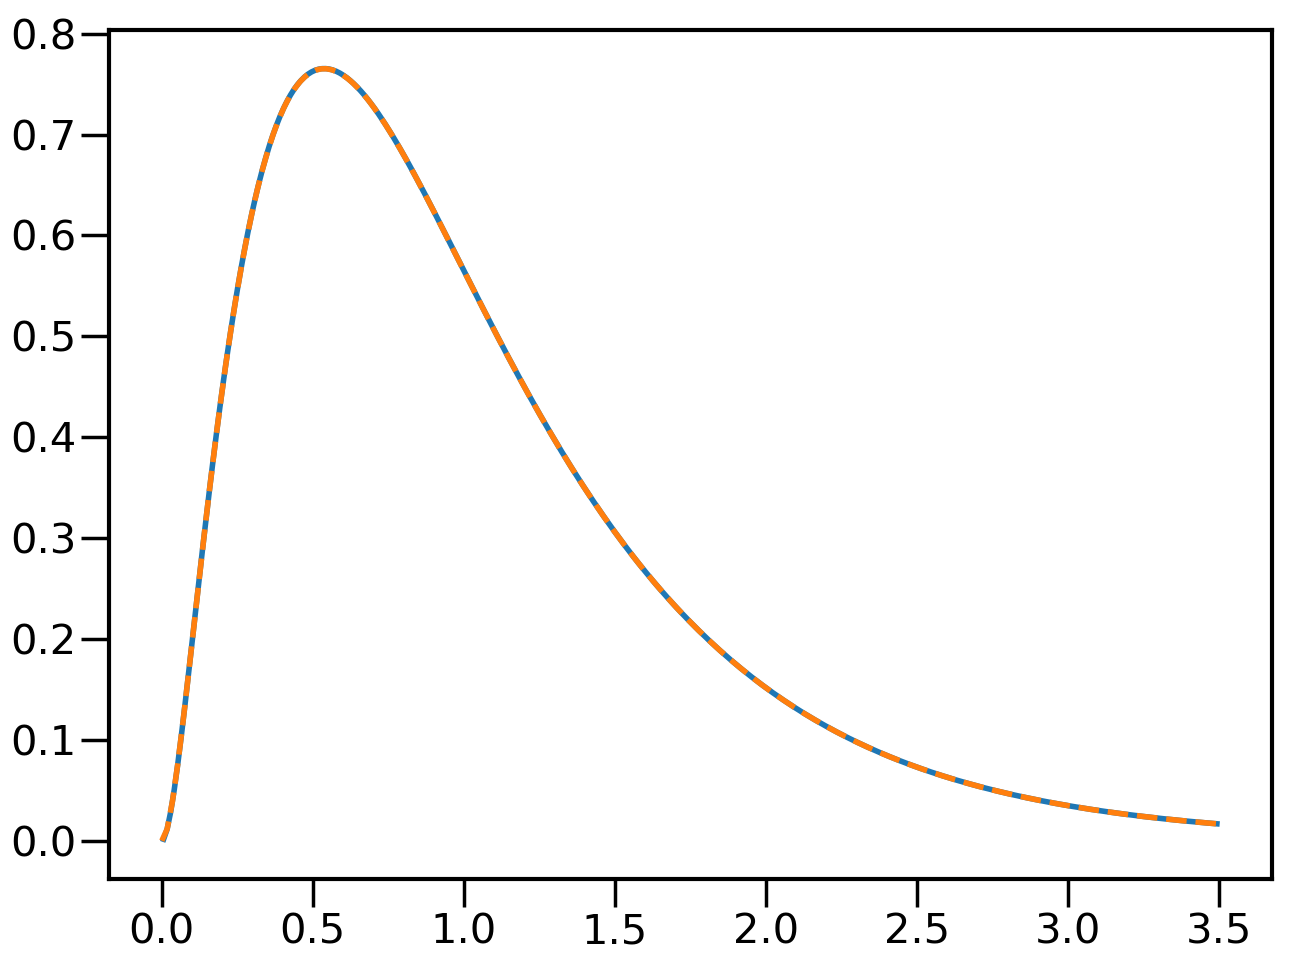

In [15]:
plot(pz['zmid'],pz['pz'])
plot(z,pzs,'--')

In [16]:
f_sky=18000./(4*np.pi/d2r**2)
# f_sky=4182./(4*np.pi/d2r**2)

In [17]:
f_sky

0.43633231299858233

In [18]:
do_xi=False
bin_xi=False
do_cov=True
bin_cl=True
l_min=2
l_max=3000
l0_cl=np.arange(l_min,l_max)

In [19]:
use_window=False
do_sample_variance=True
SSV_cov=False
tidal_SSV=True
sigma_gamma=0.26

In [20]:
import cov_3X2
reload(cov_3X2)
from cov_3X2 import *

In [21]:
CL=cov_3X2(zs_bins=zs_bins,l=l0_cl,do_cov=do_cov,bin_cl=bin_cl,zg_bins=None,l_bins=l_bins,
            do_sample_variance=do_sample_variance,use_window=use_window,
            SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=False,f_sky=f_sky,
           power_spectra_kwargs={'pk_func':'camb_pk_too_many_z'},
            #sigma_gamma=sigma_gamma)#ns=np.inf)
          )

./cov_utils.py:62: RuntimeWarning: invalid value encountered in true_divide
  Win0=2*jn(1,l_th)/l_th


In [22]:
corr=('shear','shear')

In [23]:
%time clG=CL.cl_tomo(cosmo_params=cosmo_params,cosmo_h=cosmo_h)
# %time clS=clG['stack'].compute()

/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Note: redshifts have been re-sorted (earliest first)
cl dict done
CPU times: user 6.49 s, sys: 27.4 ms, total: 6.51 s
Wall time: 1.85 s


In [24]:
l_bins

array([  20.        ,   27.84729778,   38.77359967,   53.9869988 ,
         75.16960158,  104.66351394,  145.72980195,  202.90905949,
        282.52345005,  393.37573211,  547.72255751,  762.62965788,
       1061.85875879, 1478.49485262, 2058.60432107, 2866.32837661])

In [25]:
crash

NameError: name 'crash' is not defined

In [ ]:
%time clS=clG['stack'].compute()

In [ ]:
cov_cl_inv=np.linalg.inv(clS['cov'])
print (np.sqrt(np.dot(clS['cl_b'],np.dot(cov_cl_inv,clS['cl_b']))))

In [ ]:
cc=CL.cov_utils
corrWL=cc.corr_matrix(clS['cov'])
pcolor(corrWL,vmin=-1,vmax=1,cmap='seismic')
title(r'$C_\ell$')
xticks([])
yticks([])
show()

In [ ]:
cc=CL.cov_utils
corrS=cc.corr_matrix(covG_shear)
pcolor(corrS,vmin=-1,vmax=1,cmap='seismic')
title('CL')
show()

In [ ]:
R=np.nan_to_num((covG_shear)/clS['cov']-1)
R.max(),R.min()

In [ ]:
pcolor(R,vmin=-1,vmax=1,cmap='seismic')

In [ ]:
plot(np.diag(R),label='$\delta C_\ell^2$ Ratio-1')
xticks([])
# yticks([])
legend()

In [ ]:
import seaborn as sns

In [ ]:
j=0
j3=0
colors=sns.color_palette()
for i in np.arange(nbins):
    for j2 in np.arange(i,nbins):
#         plot(lb,shear['cl'][j:j+20][:15],label=[i,j2])
#         plot(lb,clS['cl'][j3:j3+15],'--')
        plot(lb,(shear['cl'][j:j+20][:15]/clS['cl_b'][j3:j3+15])**2-1,label=[i,j2],c=colors[j2])
        
        cov0S=R[i*15:(i+1)*15,j2*15:(j2+1)*15]
#         cov0=clS['cov'][i*15:(i+1)*15,j2*15:(j2+1)*15]
        plot(lb,np.diag(cov0S),'--',c=colors[j2])
        j+=20
        j3+=15
        xscale('log')
#         yscale('log')
        legend()
    show()

In [ ]:
clG['cl'].keys()

In [ ]:
for i in np.arange(nbins):
    for j in np.arange(i,nbins):
        lens1 = ccl.ClTracerLensing(ccl_cosmo, False, z=zs_bins[i]['z'], n=zs_bins[i]['pz'])
        lens2 = ccl.ClTracerLensing(ccl_cosmo, False, z=zs_bins[j]['z'], n=zs_bins[j]['pz'])
        cls = ccl.angular_cl(ccl_cosmo, lens1, lens2, CL.l)
        plot(CL.l,clG['cl'][corr][(i,j)].compute()/cls,label=(i,j))
        xscale('log')
#         yscale('log')
        xlabel(r'$\ell$')
        ylabel(r'$C_\ell$')
        hlines(1,2,1000)
        legend()
        ylim(0.9,1.1)
    show()

In [ ]:
m1m2=(2,2)
cp=['r','b','g','y']#sns.color_pallete()
for i in np.arange(nbins):
    for j in np.arange(i,nbins):
        lens1 = ccl.ClTracerLensing(ccl_cosmo, False, z=zs_bins[i]['z'], n=zs_bins[i]['pz'])
        lens2 = ccl.ClTracerLensing(ccl_cosmo, False, z=zs_bins[j]['z'], n=zs_bins[j]['pz'])
        cls = ccl.angular_cl(ccl_cosmo, lens1, lens2, CL.l)
        cls_b=CL.binning.bin_1d(xi=cls,bin_utils=CL.cl_bin_utils)
        plot(lb,cls_b,)#color=cp[j],ls=':')
        
    xscale('log')
    yscale('log')
    xlabel(r'$\ell$')
    ylabel(r'$C_\ell$')
    legend(ncol=3)
    show()